## Image Classification

In this tutorial we we will implement a linear classifier using a softmax function and a negative log likelihood loss. These terms will be more clear as we finish this tutorial and through the lectures. The idea is that you will learn these concepts by attending lectures, doing background reading, and completing this lab. Pytorch contains a powerful set of libraries for training complex machine learning and deep learning models but for this tutorial we will be implementing things from zero, so pytorch will only be used as a matrix manipulation toolkit.


### 1. First let's load some training data and explore the data


We will be using the FashionMNIST dataset. FashionMNIST is a dataset consisting of 60k training images belonging to 10 categories of garments. A validation set is also provided which contains 10k images. The images are rescaled to a size of 28x28 pixels. This is a relatively small dataset that can be loaded entirely in memory so it is very convenient to experiment with. Most state-of-the-art methods usually try experiments in much larger datasets with either millions of images, or images with a higher resolution and more complex categories. You need to be more clever about dataloading and reading in case of larger datasets that do not fit into memory but pytorch offers parallel data loaders and other useful tools for those other larger datasets.

Pytorch already has a Dataset class for FashionMNIST so we just have to learn to use it. You should also check the ImageFolder data loader which could be useful for some of your projects, and all other datasets that come easy data loaders for your use in case you want to use them for your projects: https://pytorch.org/docs/stable/torchvision/datasets.html. If you want to use a custom dataset, you should learn to create your own Dataset classes by inheriting from torch.utils.data.Dataset. You only have to implement two functionalities: \__getitem\__ and \__len\__. Pytorch is opensource so you can check the code for the existing Dataset classes here: https://github.com/pytorch/vision/tree/master/torchvision/datasets


In [1]:
import torch, torchvision, matplotlib
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
from torchvision.datasets import FashionMNIST
matplotlib.rc('image', cmap = 'gray')

image_index = 13735  # Feel free to change this.

# The 10 categories of objects in FashionMNIST.
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal',
           'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Load the dataset.
trainset = FashionMNIST(root = './data', train = True, download = True)

# 1. Datasets need to implement the __len__ method for this to work.
print('This dataset has {0} training images'.format(len(trainset)))

# 2. Datasets need to implement the  __getitem__ method for this to work.
img, label = trainset[image_index]  # Returns image and label.

# Converts from PIL Image to torch.Tensor
img = F.to_tensor(img) 

print('Image {0} is a {1}'.format(image_index, classes[label]))
print('Image size is {0}x{1}x{2}'.format(img.shape[0], img.shape[1], img.shape[2]))
# All images have 1 channel x 28 rows x 28 columns.

# Display the image.
plt.figure()
plt.imshow(img[0]);
plt.grid(False); plt.axis('off')
plt.show()

This dataset has 60000 training images
Image 13735 is a Dress
Image size is 1x28x28


<Figure size 640x480 with 1 Axes>

There are a couple of things you have to notice: (1) Images returned from the dataset are PIL images which is a data structure to hold images from the PIL python library: https://pillow.readthedocs.io/en/3.1.x/index.html. (2) We can convert it to a tensor using pytorch's to_tensor function, and (3) the pytorch tensor has dimensions $1\times 28 \times 28$, representing number of channels, height, and width of the image. Since it is grayscale the image only has one channel, and (4) when we show the image using matplotlib we index the first dimension so that we pass only a $28 \times 28$ matrix to the imshow function.

Let's show a group of images from the dataset to have a better idea of what the images look like in the whole dataset.

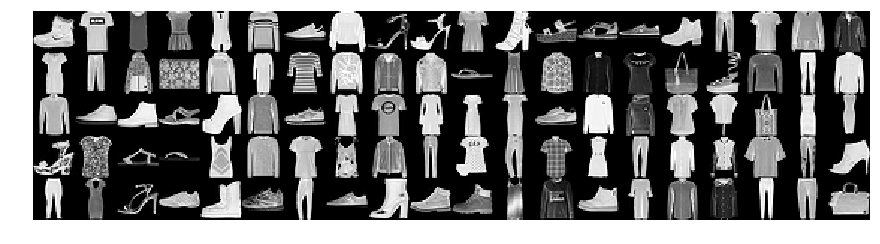

In [2]:
sample_imgs = list()
for i in range(0, 100):
    # We don't do anything with the returned labels so we just use underscore _
    img, _ = trainset[i]
    sample_imgs.append(F.to_tensor(img))
    
# Code below creates a grid of images and displays them.
# Note: the number of images in the list has to be divisible by ncols.
def show_images(images, ncols = 20):
    # mosaic the images in a grid of width = ncols
    imrows = list()
    for i in range(0, int(len(images) / ncols)):
      start = i * ncols
      buff = torch.cat(images[start:start + ncols], 2)[0]
      imrows.append(buff)
    fullimage = torch.cat(imrows, 0)
    plt.figure(figsize=(15,50)); plt.imshow(fullimage);
    plt.grid(False); plt.axis('off')
    plt.show()

# Show images below at 2.0x zoom level. Remember they are 32x32 pixels only.
show_images(sample_imgs, ncols = 20)

Now let's show only images of "Dress", but feel free to use the code below to visualize some of the other categories.

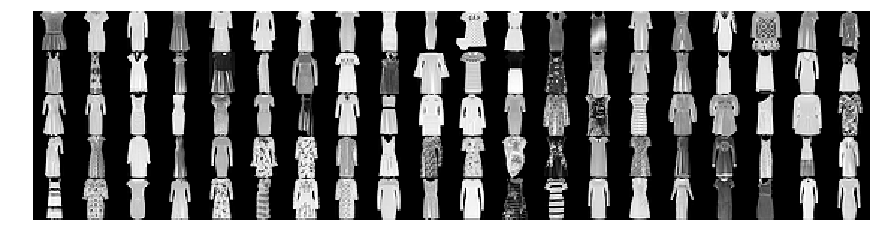

In [3]:
sample_imgs = list()
for i in range(0, len(trainset)):
    img, category_id = trainset[i]
    if classes[category_id] == "Dress":
      sample_imgs.append(F.to_tensor(img))
      if len(sample_imgs) == 100:
        break

show_images(sample_imgs, ncols = 20)

### 2. Anatomy of a  Softmax Classifier

The classifier will take input vectors $x$ of size $1x28x28 = 784$, which is the size of the images. The classifier will output vector predictions of size $10$, where each entry corresponds to a category. The function representing the linear classifier is:  

$$\hat{y} = softmax(Wx+b)$$

where the $softmax$ function is applied to each element in the vector $a = Wx + b$. The weight matrix $W$ is of size 10x784, and $b$ is a bias vector of size 10, so the output vector $a$ is of size 10 to match the number of categories that we want to predict. Both $W$ and $b$ need to be "learned" or estimated using the training dataset. The softmax function is defined for each entry $a_i$ in the vector $a$ as:

$$\hat{y}_i = softmax(a_i) = \frac{exp(a_i)}{\sum_{k=1}^{10}{exp(a_k)}}$$

The softmax function forces the entries in the vector $\hat{y}$ to sum to 1. We will discuss in the next section and during class in more detail why this transformation is convenient, and what other options we could have.


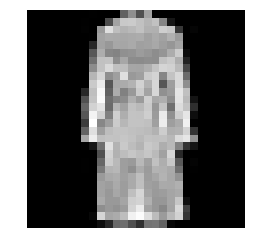

y_hat[T-shirt/top] = 0.10
y_hat[Trouser] = 0.10
y_hat[Pullover] = 0.12
y_hat[Dress] = 0.10
y_hat[Coat] = 0.09
y_hat[Sandal] = 0.11
y_hat[Shirt] = 0.11
y_hat[Sneaker] = 0.10
y_hat[Bag] = 0.08
y_hat[Ankle boot] = 0.10


In [4]:
# Softmax function: exp(a) / sum(exp(a))
# Note that this function works for tensors of any shape, it is not a scalar function.
def softmax(a):
    max_val = a.max()  # This is to avoid variable overflows.
    exp_a = (a - max_val).exp()
    return exp_a.div(exp_a.sum())

# Classification function: y = softmax(Wx + b)
# Again, note this function is operating on vectors.
def linear(x, weight, bias):
    return torch.matmul(weight, x) + bias

# Initialize bias and weight with random values.
weight = torch.zeros(10, 1 * 28 * 28).normal_(0, 0.01)
bias = torch.zeros(10, 1).normal_(0, 0.01)

# Now predict the category for one image using this un-trained classifier.
img, label = trainset[image_index]
img = F.to_tensor(img)
x = img.view(1 * 28 * 28, 1)
a = linear(x, weight, bias)
predictions = softmax(a)

# Show the results of the classifier.
# Display the image.
plt.figure(); plt.imshow(img[0]);
plt.grid(False); plt.axis('off'); plt.show()
max_score, max_label = predictions.max(0)
for (i, pred) in enumerate(predictions.squeeze().tolist()):
    print('y_hat[%s] = %.2f' % (classes[i], pred))

Now we have a working classifier but it is not a very good one. The rest of this lab will deal with "training" or "learning" the weight and bias parameters that minimize the number of errors of the classifier in the training data. Under certain conditions the parameters learned in the training data will also be generally good to make predictions on other data not seen during training. This property is called generalization. We will discuss in class more about those concepts.  


### 3. Computing the loss or cost between a correct prediction and a wrong prediction.


The first step to train our weight and bias parameters is to define a criterion for how wrong (or good) are the predictions given a set of weights and bias parameters. Loss functions measure the "distance" between a prediction $\hat{y}$ and a true label $y$. In the case of softmax, you can think of your true label $Dress$ as a vector with all zeros except in the entry corresponding to $Dress$ where it is one, e.g. $y = [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]$. The loss function $\ell(y,\hat{y})$ between the prediction and true label is given then simply by the following equation: 
$$\ell(y, \hat{y})= -\sum_iy_ilog(\hat{y}_i)$$

Since the true label vector $y$ only has one non-zero entry, we know this sum really has only one term that is non-zero so you will usually see this loss function simply stated as:

$$\ell(label, \hat{y}) = -log(\hat{y}_{label})$$

The intuition behind this loss function is that we want the prediction score corresponding to the true label to be as high as possible (close to one), and by doing this we will also push the other scores to go close to zero because the softmax function forces these scores to sum to one. Since we want to pose the problem as a minimization problem, we use $-log(y_{label})$. 

In [5]:
def loss(label, predictions):
    return -predictions[label].log()

# Let's compute predictions again.
predictions = softmax(linear(x, weight, bias))

for (i, pred) in enumerate(predictions.squeeze().tolist()):
    trueval = (i == label)
    print('y[{0}] = {1}\ny_hat[{0}] = {2:.2f}\n'.format(classes[i], trueval, pred))

# The correct label for this image is 'frog'.
loss_value = loss(3, predictions)
print('\nLoss = -sum(y[i] * log[y_hat[i]]) = -log[y_hat[{0}]] = {1:.4f}'.format(classes[label], loss_value[0]))

y[T-shirt/top] = 0
y_hat[T-shirt/top] = 0.10

y[Trouser] = 0
y_hat[Trouser] = 0.10

y[Pullover] = 0
y_hat[Pullover] = 0.12

y[Dress] = 1
y_hat[Dress] = 0.10

y[Coat] = 0
y_hat[Coat] = 0.09

y[Sandal] = 0
y_hat[Sandal] = 0.11

y[Shirt] = 0
y_hat[Shirt] = 0.11

y[Sneaker] = 0
y_hat[Sneaker] = 0.10

y[Bag] = 0
y_hat[Bag] = 0.08

y[Ankle boot] = 0
y_hat[Ankle boot] = 0.10


Loss = -sum(y[i] * log[y_hat[i]]) = -log[y_hat[Dress]] = 2.3234


### 4. Computing Numerical Gradients for parameters $W$ and $b$


The rest of this lab will be about modifying the parameters $W$ and $b$ so that the loss for all the images in the training set is as small as possible. Randomly modifying the values of these parameters until finding a set of values for which the loss becomes smaller might work reasonably well when few parameters need to be estimated but our weight matrix $W$ alone has 784x10 = 7840 parameters, and some models that we will study later in the class will have billions of parameters.

We will instead use Stochastic Gradient Descent (SGD), which is an optimization technique that consists on computing the loss for a training sample (plain SGD) or a small group of training samples (minibatch SGD) and modifying the parameters $W$ and $b$ by shifting them by a small amount in the direction of their gradients (with respect to the loss objective), we will go over this in more detail later. We will first focus on how to compute those gradients, particularly $\partial \ell / \partial w_{ij}$ and $\partial \ell / \partial b_i$. 

A simple yet effective first approach is to compute the gradients with a numerical approximation using the definition of derivatives (below is the definition for single valued functions): $$f'(x) = lim_{h\rightarrow0}\frac{f(x + h) - f(x - h)}{2h}.$$ 
For a given single input pair $(x, y)$ the output of the loss function $\ell$ just depends on the parameters $W$ and $b$. Taken this into account, for each entry $w_{ij}$ in the weight matrix $W$ we are interested in the following:

$$\frac{\partial \ell(W,b)}{\partial w_{ij}} = \frac{\ell(W + \mathcal{E}_{ij},b) - \ell(W - \mathcal{E}_{ij}, b)}{2\epsilon}, $$

where $\mathcal{E}_{ij}$ is a matrix that has a small value $\epsilon$ in its $(i,j)$ entry and zeroes everywhere else. Intuitively this gradient tells us how would the value of the loss change if we shake a particular weight $w_{ij}$ by an $\epsilon$ amount. We can do the same to compute derivatives with respect to the bias parameters $b_i$. Next we write code to compute gradients for a loss computed on a single image.

In [6]:
epsilon = 0.001
shifted_weight = weight.clone()  # Make a copy of the weights.

# Initialize gradients for bias and weight with zero values.
gradWeight = torch.zeros(10, 1 * 28 * 28)
gradBias = torch.zeros(10, 1)

# Compute gradients for each weight w_ij
for i in range(0, weight.shape[0]):
    for j in range(0, weight.shape[1]):
      
        # Compute f(x + h)
        shifted_weight[i, j] = shifted_weight[i, j].item() + epsilon
        f1 = softmax(linear(x, shifted_weight, bias))
        loss1 = loss(label, f1)
        shifted_weight[i, j] = weight[i, j] # restore original value.
        
        # Compute f(x - h)
        shifted_weight[i, j] = shifted_weight[i, j].item() - epsilon
        f2 = softmax(linear(x, shifted_weight, bias))
        loss2 = loss(label, f2)
        shifted_weight[i, j] = weight[i, j] # restore original value.

        # Compute [f(x + h) - f(x - h)] / 2h.
        #print(loss1, loss2)
        gradWeight[i, j] = (loss1.item() - loss2.item()) / (2 * epsilon)

numericalGradWeight = gradWeight # Let's save this variable with another name.
print(numericalGradWeight[:10, 320:325]) # Print a subset of the gradients.

tensor([[ 0.0577,  0.0720,  0.0638,  0.0848,  0.0691],
        [ 0.0521,  0.0652,  0.0578,  0.0768,  0.0626],
        [ 0.0651,  0.0814,  0.0720,  0.0957,  0.0782],
        [-0.4953, -0.6191, -0.5482, -0.7287, -0.5943],
        [ 0.0482,  0.0601,  0.0533,  0.0709,  0.0578],
        [ 0.0610,  0.0763,  0.0677,  0.0899,  0.0732],
        [ 0.0620,  0.0776,  0.0687,  0.0912,  0.0744],
        [ 0.0534,  0.0669,  0.0592,  0.0787,  0.0641],
        [ 0.0427,  0.0534,  0.0473,  0.0628,  0.0514],
        [ 0.0528,  0.0662,  0.0587,  0.0778,  0.0635]])


In the above code we have used the method .item(), please read on pytorch's documentation on "0-dimensional scalar tensors" about why we need this: https://pytorch.org/blog/pytorch-0_4_0-migration-guide/#support-for-0-dimensional-scalar-tensors

### 5. Computing Analytic Gradients for parameters $W$ and $b$


Unfortunately computing numerical gradients requires running the function f as many times as the number of parameters in the model which could be a very large number. In practice, gradients are computed analytically instead of numerically. This means we will be computing the derivatives $\partial \ell/\partial w_{ij}$ and $\partial \ell/\partial b_{i}$ by first deriving their analytic equation using our knowledge of basic calculus. Typically we do not compute the derivatives with respect to the parameters directly but the derivatives with respect to inputs or outputs, and use those to compute the derivatives with respect to the parameters using the chain rule. First let's write here again our loss function $\ell$ for a single training example $(x, label)$:

\begin{equation}
\ell(W, b) = -\text{log}(\hat{y}_{label}(W, b)) = -\text{log}\Big(\frac{\text{exp}(a_{label}(W, b))}{\sum_{k=1}^{10}{\text{exp}(a_k(W,b))}}\Big)
\end{equation}

For simplicity we will drop the parameters $W$ and $b$ from the notation but it is important to remember what variables depend on them.

\begin{equation}
\ell = -\text{log}\Big(\frac{\text{exp}(a_{label})}{\sum_{k=1}^{10}{\text{exp}(a_k)}}\Big)
\end{equation}

We will compute the derivatives with respect to parameters $w_{ij}$ and $b_i$ using the chain rule as:

\begin{equation}
\frac{\partial \ell}{\partial w_{ij}} = \frac{\partial \ell}{\partial a_{i}}\frac{\partial a_i}{\partial w_{ij}}
\quad\text{and}\quad
\frac{\partial \ell}{\partial b_{i}} = \frac{\partial \ell}{\partial a_{i}}\frac{\partial a_i}{\partial b_{i}}
\end{equation}

These derivatives correspond to the following expressions (you can trust this for now, but an appendix with careful derivations is included at the end, or even better you can try deriving it yourself on paper):

\begin{equation}
\frac{\partial \ell}{\partial a_{i}} = \frac{\partial}{\partial a_{i}}\Big[-\text{log}\Big(\frac{\text{exp}(a_{label})}{\sum_{k=1}^{10}{\text{exp}(a_k)}}\Big)\Big] = \hat{y}_{i} - y_i  \tag{See Appendix, or derive it yourself}
\end{equation}

\begin{equation}
\frac{\partial a_i}{\partial w_{ij}} = \frac{\partial}{\partial w_{ij}} (w_{i,1}x_1 + ... + w_{ij}x_j + ... + w_{i, 784}x_{784} + b_i) = x_j
\end{equation}

\begin{equation}
\frac{\partial a_i}{\partial b_{i}} = \frac{\partial}{\partial b_{i}} (w_{i,1}x_1 + ... + w_{ij}x_j + ... + w_{i, 784}x_{784} + b_i) = 1 
\end{equation}

Next we will compute the gradients with respect to parameters using the formulas above for a single image and compare them with the ones obtained using our numerical gradients for the same image:

In [7]:
# This computes dL / da = y_hat - y.
def loss_softmax_backward(label, predictions):
    grad_inputs = predictions.clone()
    grad_inputs[label] = grad_inputs[label].item() - 1
    return grad_inputs

# This computes dL / dW[i,j] = (dL / da) * (da / dW[i,j])
#           and dL / dB[i] = (dL / da) * (da / dB[i,j])
def linear_backward(x, weight, bias, gradOutput):
    gradBias = bias.clone().zero_()
    gradWeight = weight.clone().zero_()
    
    gradWeight = gradOutput * x.t()   # dL / dW[i,j] = x[j] * dL / da 
    gradBias.copy_(gradOutput)   # dL / dB[i] = 1 * dL / da
    
    return gradWeight, gradBias

# Compute dL / da
gradOutput = loss_softmax_backward(label, predictions)
# Compute dL / dW[i,j] and dL / dB[i]
gradWeight, gradBias = linear_backward(x, weight, bias, gradOutput)

# Print same subset of the gradients as before (they should be similar).
print(gradWeight[:10, 320:325]) 

# Compare the gradients computed analytically with numerical gradients.
g1 = gradWeight.view(-1, 1).squeeze()
g2 = numericalGradWeight.view(-1, 1).squeeze()
print('Distance betwen numerical and analytical gradients: %.6f' % 
      (torch.norm(g1 - g2) / torch.norm(g1 + g2)))

tensor([[ 0.0576,  0.0721,  0.0638,  0.0848,  0.0692],
        [ 0.0522,  0.0652,  0.0577,  0.0768,  0.0626],
        [ 0.0651,  0.0814,  0.0721,  0.0958,  0.0781],
        [-0.4953, -0.6191, -0.5483, -0.7287, -0.5943],
        [ 0.0482,  0.0602,  0.0533,  0.0709,  0.0578],
        [ 0.0611,  0.0763,  0.0676,  0.0899,  0.0733],
        [ 0.0620,  0.0775,  0.0686,  0.0912,  0.0744],
        [ 0.0535,  0.0668,  0.0592,  0.0787,  0.0642],
        [ 0.0428,  0.0534,  0.0473,  0.0629,  0.0513],
        [ 0.0529,  0.0661,  0.0586,  0.0778,  0.0635]])
Distance betwen numerical and analytical gradients: 0.000139


The above code should ouptut gradients that are very similar to the approximate gradients computed numerically. This is a very common test to determine if an implementation of a function optmized with stochastic gradient descent is correct. Computing the gradients numerically is easy to implement but expensive to execute, as we needed to shift every parameter by an epsilon amount and re-run the function every time. While we obtain the gradients analytically in a single pass.

### 6. Stochastic Gradient Descent (SGD)

Now that we compute gradients efficiently we will implement the stochastic gradient descent loop that moves the weights according to the gradients. In each iteration we sample an (input, label) pair and compute the gradients of the parameters, then we update the parameters according to the following rules:

$$w_{ij} = w_{ij} - \lambda\frac{\partial \ell}{\partial w_{ij}}$$

$$b_i = b_i - \lambda\frac{\partial \ell}{\partial b_i}$$

where $\lambda$ is the learning rate. This value is set empirically and is usually modified during training. We will provide additional practical advice on choosing the learning rate as well as other tricks during class but there is no single general advice for this. These are generally empirically determined -- as in you try and see what works. Maybe over time with experience you will develop the ability to choose them appropriately on your first try based on the initialization of the parameters, the type of operations involved, the types of regularizations used together with the training method. 

We implement next a basic stochastic gradient descent loop with N epochs. This means we will roughly go over all training examples N times. You can also see how the loss decreases while the accuracy increases. It is usually a good idea to keep track of these two when you train any model. Another question is: When do we stop? This is where the validation data comes into play, we compute the accuracy on the validation data and we stop when the accuracy on the validation data does not improve anymore. Run the cell below and be patient because this will take a couple of minutes.

In [8]:
# Load the validation dataset.
valset = FashionMNIST(root = './data', train = False, download = True)

# Define a learning rate. 
learningRate = 1e-4

# Define number of epochs.
N = 5

# Initialize bias and weight with random values again.
weight = torch.empty(10, 1 * 28 * 28).normal_(0, 0.01)
bias = torch.zeros(10, 1)

# log accuracies and losses.
train_accuracies = []; val_accuracies = []
train_losses = []; val_losses = []

# Training loop. Please make sure you understand every single line of code below.
# Go back to some of the previous steps in this lab if necessary.
for epoch in range(0, N):
    correct = 0.0
    cum_loss = 0.0
    
    # Make a pass over the training data.
    for (i, (img, label)) in enumerate(trainset):
        x = F.to_tensor(img)
        x = x.view(1 * 28 * 28, 1)
        
        # Forward pass. (Prediction stage)
        predictions = softmax(linear(x, weight, bias))
        cum_loss += loss(label, predictions).item()
        max_score, max_label = predictions.max(0)
        if max_label[0] == label: correct += 1
        
        #Backward pass. (Gradient computation stage)
        gradOutput = loss_softmax_backward(label, predictions)
        gradWeight, gradBias = linear_backward(x, weight, bias, gradOutput)
        
        # Parameter updates.
        weight.add_(-learningRate, gradWeight)
        bias.add_(-learningRate, gradBias)
        
        # Logging the current results on training.
        if (i + 1) % 10000 == 0:
            print('Train-epoch %d. Iteration %05d, Avg-Loss: %.4f, Accuracy: %.4f' % 
                  (epoch, i + 1, cum_loss / (i + 1), correct / (i + 1)))
    
    train_accuracies.append(correct / len(trainset))
    train_losses.append(cum_loss / len(trainset))
    
    
    # Make a pass over the validation data.
    correct = 0.0
    cum_loss = 0.0
    for (i, (img, label)) in enumerate(valset):
        x = F.to_tensor(img)
        x = x.view(1 * 28 * 28, 1)
        
        # Forward pass. (Prediction stage)
        predictions = softmax(linear(x, weight, bias))
        cum_loss += loss(label, predictions).item()
        max_score, max_label = predictions.max(0)
        if max_label[0] == label: correct += 1
          
          
    val_accuracies.append(correct / len(valset))
    val_losses.append(cum_loss / len(valset))
            
    # Logging the current results on validation.
    print('Validation-epoch %d. Avg-Loss: %.4f, Accuracy: %.4f' % 
          (epoch, cum_loss / len(valset), correct / len(valset)))

Train-epoch 0. Iteration 10000, Avg-Loss: 1.6674, Accuracy: 0.5808
Train-epoch 0. Iteration 20000, Avg-Loss: 1.4248, Accuracy: 0.6258
Train-epoch 0. Iteration 30000, Avg-Loss: 1.2870, Accuracy: 0.6473
Train-epoch 0. Iteration 40000, Avg-Loss: 1.1923, Accuracy: 0.6662
Train-epoch 0. Iteration 50000, Avg-Loss: 1.1245, Accuracy: 0.6800
Train-epoch 0. Iteration 60000, Avg-Loss: 1.0721, Accuracy: 0.6907
Validation-epoch 0. Avg-Loss: 0.8129, Accuracy: 0.7375
Train-epoch 1. Iteration 10000, Avg-Loss: 0.7844, Accuracy: 0.7543
Train-epoch 1. Iteration 20000, Avg-Loss: 0.7742, Accuracy: 0.7578
Train-epoch 1. Iteration 30000, Avg-Loss: 0.7642, Accuracy: 0.7607
Train-epoch 1. Iteration 40000, Avg-Loss: 0.7517, Accuracy: 0.7661
Train-epoch 1. Iteration 50000, Avg-Loss: 0.7415, Accuracy: 0.7691
Train-epoch 1. Iteration 60000, Avg-Loss: 0.7328, Accuracy: 0.7711
Validation-epoch 1. Avg-Loss: 0.7028, Accuracy: 0.7716
Train-epoch 2. Iteration 10000, Avg-Loss: 0.6811, Accuracy: 0.7850
Train-epoch 2. Iter

The code above should give us about about 80% accuracy on this task. Not bad! considering this is not a deep learning model, but a simple linear classifier and given that we didn't compute any features from the image, but fed images directly into the classifier.

### 7. Analyzing the results of this classifier

Now that we have a trained model that produces good results on our validation set we can do a few things such as visualizing what are the result of this model on images from the validation set. Before that, we will plot the training and validation accuracy, as well as the training and validation losses.

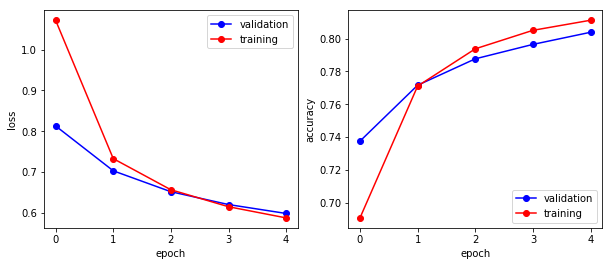

In [9]:
plt.figure(figsize = (10, 4))
plt.subplot(1, 2, 1)
plt.plot(val_losses, 'bo-', label = 'val-loss')
plt.plot(train_losses, 'ro-', label = 'train-loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['validation', 'training'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, 'bo-', label = 'val-acc')
plt.plot(train_accuracies, 'ro-', label = 'train-acc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['validation', 'training'], loc='lower right')
plt.show()

There are a couple of things you should notice in the two plots above (1) The recorded accuracy after the first epoch is higher in the validation set than in the training set. Why is this? (2) The accuracy seems to keep going up in both training and validation after the last epoch.This shows we could probably get a better model if we keep training it for more epochs. (3) The gap in the accuracy between training and validation is becoming wider the more epochs the model has trained. Could it be the case that the validation accuracy will eventually decrease while the training accuracy keeps increasing?



Next, we are going to visualize the predictions for one image in the validation set (not used for training the weights or parameters of the model).

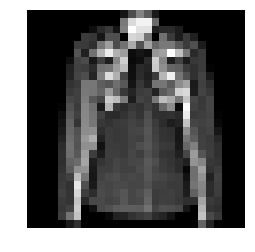

y_hat[T-shirt/top] = 0.01
y_hat[Trouser] = 0.02
y_hat[Pullover] = 0.16
y_hat[Dress] = 0.01
y_hat[Coat] = 0.52
y_hat[Sandal] = 0.01
y_hat[Shirt] = 0.26
y_hat[Sneaker] = 0.00
y_hat[Bag] = 0.01
y_hat[Ankle boot] = 0.00


In [10]:
# Now predict the category for one image using the trained classifier.
img, label = valset[135]  # Try visualizing the outputs for different images.
img = F.to_tensor(img)
x = img.view(1 * 28 * 28, 1)
a = linear(x, weight, bias)
predictions = softmax(a)

# Show the results of the classifier.
# Display the image.
plt.figure(); plt.imshow(img[0]);
plt.grid(False); plt.axis('off'); plt.show()
max_score, max_label = predictions.max(0)
for (i, pred) in enumerate(predictions.squeeze().tolist()):
    print('y_hat[%s] = %.2f' % (classes[i], pred))

## Assignment Questions [10pts]

* **[2pts] **Load the weight and bias parameters in the following file http://vicenteordonez.com/deeplearning/model_params.pth using the torch.load function and show below the top image for each category where the model (defined by the loaded parameters) performs the best (display the images in a single row), and below please plot the top image for each category where the model performs the worst (display the images in a single row). Your resulting picture will show 10 images arranged in a 2x10 grid. Please refer to some of the code used in section 1 in order to do this. **Important:** Only consider images in the validation set.

In [11]:
# Your code goes here.
model_params = torch.load('model_params.pth')

In [12]:
weight = model_params['weight']
bias = model_params['bias']

In [13]:
best, worst = [], []
for i in range(10):
    best.append([None, 1e10])
    worst.append([None, -1e10])
for i in range(len(valset)):
    x, y = valset[i]
    x = F.to_tensor(x)
    x = x.view(1*28*28,1)
    predi = softmax(linear(x, weight, bias))
    Loss = loss(y, predi).item()
    label = y.item()
    if best[label][1] > Loss:
        best[label][0] = i
        best[label][1] = Loss
    if worst[label][1] < Loss:
        worst[label][0] = i
        worst[label][1] = Loss
        

In [14]:
imgs = []
for i in range(20):
    if i < 10:
        img, _ = valset[best[i][0]]
        imgs.append(F.to_tensor(img))
    else:
        img, _ = valset[worst[i%10][0]]
        imgs.append(F.to_tensor(img))

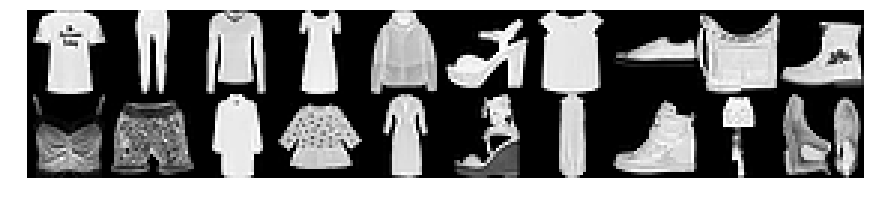

In [15]:
show_images(imgs, 10)

* **[2pts]** Generate the visualization of the model weights learned in the FashionMNIST model using the weights in http://vicenteordonez.com/deeplearning/model_params.pth using a similar approach as the one described in the Stanford's CS231n lecture notes http://cs231n.github.io/linear-classify/ but for FashionMNIST categories.

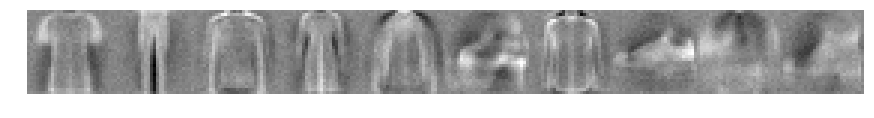

In [16]:
imgs = []
for i in range(10):
    w = weight[i].view(1, 28, 28)
    imgs.append(w)
show_images(imgs, 10)

* ** [2pts] ** The linear model presented in this assignment uses a softmax function with a negative log likelihood loss to make predictions. Instead for this part you are requested to consider a similar classifier but without any softmax function but using a margin-loss instead. The score predictions are not between zero and one and instead are obtained directly by computing $\hat{y} = Wx + b$, and the loss function between the vector of predictions $\hat{y}$ and the true $label$ has to be a margin loss. This loss encourages the prediction corresponding to the correct category  to be larger than the predictions for all other categories by a $\Delta$ amount. The margin loss definition is stated formally as follows:

$$ \ell(label, \hat{y}) = \sum_{k \; \neq {\text{ label}}} [max(0, \hat{y}_k  - \hat{y}_{label} + \Delta)],$$



Write below the analytical derivations for $\partial \ell / \partial w_{i,j}$ and $\partial \ell / \partial b_i$, ignore the fact that $max$ has a non-differentiable inflexion point. Show the full derivation. For an example of how to do this, please see the derivation included in this assignment for the softmax classifier in section 5 and in the included Appendix. Feel free to reuse the latex or part of the derivations included there which stay the same (e.g. this classifier also has a linear layer so using the chain rule that part should stay the same). **Hints:** As in the softmax classifier you will also need to compute the gradients by separating the two cases when $i = label$ and when $i \neq label$. To compute gradients for the $max$ function you will also need the indicator function $ 1[\text{condition}]$, which has a value of one if the condition inside brackets is true or zero otherwise, e.g. $1[\gamma < 3]$ has a value of one only if the argument $\gamma$ is less than 3, otherwise it is zero.

In [17]:
# This solution doesn't require any code. If you don't want to typeset 
# your math in LaTeX in the text cell above, include a scanned image 
# with your solution as an additional attachment on UVA Collab. 
# Your solution has to be easily legible.

In
\begin{equation}
\ell(W, b) = \sum_{k \; \neq {\text{ label}}} [max(0, \hat{y}_k  - \hat{y}_{label} + \Delta)] = \sum_{k \; \neq {\text{ label}}} [max(0, a_k(W, b) - a_{label}(W, b) + \Delta)]
\end{equation}
where
\begin{equation}
a_k(W, b) = (Wx+b)_k
\end{equation}
\begin{equation}
\ell = \sum_{k \; \neq {\text{ label}}} [max(0, a_k - a_{label} + \Delta)]
\end{equation}

Using chain rule:

\begin{equation}
\frac{\partial \ell}{\partial w_{ij}} = \frac{\partial \ell}{\partial a_{i}}\frac{\partial a_i}{\partial w_{ij}}
\quad\text{and }\quad
\frac{\partial \ell}{\partial b_{i}} = \frac{\partial \ell}{\partial a_{i}}\frac{\partial a_i}{\partial b_{i}}
\end{equation}

When $i = label$:
$$\frac{\partial \ell}{\partial a_i} = \frac{\partial \ell}{\partial a_{label}} = \frac{\partial}{\partial a_{label}} \sum_{k \; \neq {\text{ label}}} [max(0, a_k - a_{label} + \Delta)] = \sum_{k \; \neq {\text{ label}}} [\frac{\partial}{\partial a_{label}}max(0, a_k - a_{label} + \Delta)]$$
$$\frac{\partial \;0}{\partial a_{label}} = 0$$
$$\frac{\partial \;(a_k - a_{label} + \Delta)}{\partial a_{label}} = -1$$
$$\frac{\partial}{\partial a_{label}}max(0, a_k - a_{label} + \Delta) = 
    \begin{cases}
      0 & \text{if $a_k - a_{label} + \Delta \leq 0$}\\
     -1 & \text{if $a_k - a_{label} + \Delta > 0$}\\
    \end{cases} $$
$$\frac{\partial \ell}{\partial a_i} = -\sum_{k \; \neq {\text{ label}}} \mathbb{1}[a_k - a_{label} + \Delta > 0]$$

When $i \neq label$:
$$\frac{\partial \ell}{\partial a_i} = \frac{\partial}{\partial a_i} \sum_{k \; \neq {\text{ label}}} [max(0, a_k - a_{label} + \Delta)] = \sum_{k \; \neq {\text{ label}}} [\frac{\partial}{\partial a_i}max(0, a_k - a_{label} + \Delta)]$$
$$\frac{\partial \;0}{\partial a_{label}} = 0$$
When $i = k$
$$\frac{\partial \;(a_k - a_{label} + \Delta)}{\partial a_i} = 1$$
$$\frac{\partial}{\partial a_i}max(0, a_k - a_{label} + \Delta) = 
    \begin{cases}
      0 & \text{if $a_k - a_{label} + \Delta \leq 0$}\\
     1 & \text{if $a_k - a_{label} + \Delta > 0$}\\
    \end{cases} 
    $$
When $i \neq k$
$$\frac{\partial \;(a_k - a_{label} + \Delta)}{\partial a_i} = 0$$
$$\frac{\partial}{\partial a_i}max(0, a_k - a_{label} + \Delta) = 0$$
When $i \neq label$:
$$\frac{\partial \ell}{\partial a_i} =  
    \begin{cases}
     0 & \text{if $a_i - a_{label} + \Delta \leq 0$}\\
     1 & \text{if $a_i - a_{label} + \Delta > 0$}\\
    \end{cases} 
    $$
Which yields: $$\frac{\partial \ell}{\partial a_i} = 
    \begin{cases}
     \mathbb{1}[\hat{y}_{i}-\hat{y}_{label}+\Delta>0] & \text{if $i \neq \text{label}$}\\
     -\sum_{k \; \neq {\text{ label}}} \mathbb{1}[\hat{y}_{k}-\hat{y}_{label}+\Delta>0] & \text{if $i = \text{label}$}\\
    \end{cases} 
$$

\begin{equation}
\frac{\partial a_i}{\partial b_{i}} = \frac{\partial}{\partial b_{i}}  (Wx + b)_i = 1 
\end{equation}

The final formula would be:

$$\frac{\partial \ell}{\partial w_{ij}} = \frac{\partial \ell}{\partial a_{i}}\frac{\partial a_i}{\partial w_{ij}} = (\mathbb{1}[\hat{y}_{i}-\hat{y}_{label}+\Delta>0]\mathbb{1}[i\neq \text{label}]-\sum_{k \; \neq {\text{ label}}} \mathbb{1}[\hat{y}_{k}-\hat{y}_{label}+\Delta>0]\mathbb{1}[{i = \text{label}}])x_j$$
$$\frac{\partial \ell}{\partial b_{i}} = \frac{\partial \ell}{\partial a_{i}}\frac{\partial a_i}{\partial b_{i}} =\mathbb{1}[\hat{y}_{i}-\hat{y}_{label}+\Delta>0]\mathbb{1}[i\neq \text{label}]-\sum_{k \; \neq {\text{ label}}} \mathbb{1}[\hat{y}_{k}-\hat{y}_{label}+\Delta>0]\mathbb{1}[{i = \text{label}}]
$$

* **[4pts]** Implement and train a model using the margin loss from the previous question and report your training/validation accuracy, and training/validation losses plots as performed earlier in this tutorial for the softmax classifier model. Do you get better results than 80%? The instructor, and TAs obtained around 83%. **Hint:** For this question you mostly have to implement margin_loss and margin_loss_backward as posed in a cell below, the code for training needs some minimal modifications from the code included in this notebook for training the softmax classifier. Most of the grade will come from a correct implementation of margin_loss and margin_loss_backwards, which is not a lot of lines of code, (again) the rest is code that you need to minimally modify from the softmax classifier code included in this assignment.

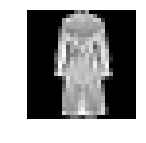

y_hat[T-shirt/top] = 0.07
y_hat[Trouser] = 0.03
y_hat[Pullover] = -0.25
y_hat[Dress] = -0.26
y_hat[Coat] = -0.19
y_hat[Sandal] = 0.09
y_hat[Shirt] = -0.22
y_hat[Sneaker] = -0.06
y_hat[Bag] = -0.01
y_hat[Ankle boot] = -0.17


In [18]:
# I provide here an example for a prediction under a max-margin model
# or forward-pass. Your task is to train a model under this loss.

# Classification function: y = max(Wx + b)

# We can keep the linear function.
def linear(x, weight, bias):
    return torch.matmul(weight, x) + bias

# Initialize bias and weight with random values as for the other model.
weight = torch.zeros(10, 1 * 28 * 28).normal_(0, 0.01)
bias = torch.zeros(10, 1).normal_(0, 0.01)

# Now predict the category for one image using this un-trained classifier.
img, label = trainset[image_index]
img = F.to_tensor(img)
x = img.view(1 * 28 * 28, 1)
a = linear(x, weight, bias)
predictions = a  # no softmax, the raw outputs are the prediction scores.

# Show the results of the classifier.
# Display the image.
plt.figure(figsize = (2, 2)); plt.imshow(img[0]);
plt.grid(False); plt.axis('off'); plt.show()
max_score, max_label = predictions.max(0)
for (i, pred) in enumerate(predictions.squeeze().tolist()):
    print('y_hat[%s] = %.2f' % (classes[i], pred))

In [22]:
# Your code goes here.
# Particularly code for the following two functions.
delta = 1.0

def margin_loss(label, predictions):
    loss = predictions.clone() - predictions[label] + delta
    zero = torch.tensor(0).float()
    loss = torch.max(loss, zero)
    loss[label] = 0
    return loss.sum()

def margin_loss_backward(label, predictions):
    grad_inputs = ((predictions.clone() - predictions[label] + delta) > 0).float()
    grad_inputs[label] = -(grad_inputs.sum() - grad_inputs[label])
    return grad_inputs
# Any other code you might need (or not).

In [24]:
# Your code for training the model goes here.
# Feel free to re-use code in this notebook.
# Define a learning rate. 
learningRate = 1e-3

# Define number of epochs.
N = 5

# Initialize bias and weight with random values again.
weight = torch.empty(10, 1 * 28 * 28).normal_(0, 0.01)
bias = torch.zeros(10, 1)

# log accuracies and losses.
train_accuracies = []; val_accuracies = []
train_losses = []; val_losses = []

# Training loop. Please make sure you understand every single line of code below.
# Go back to some of the previous steps in this lab if necessary.
for epoch in range(0, N):
    correct = 0.0
    cum_loss = 0.0
    
    # Make a pass over the training data.
    for (i, (img, label)) in enumerate(trainset):
        x = F.to_tensor(img)
        x = x.view(1 * 28 * 28, 1)
        
        # Forward pass. (Prediction stage)
        predictions = linear(x, weight, bias)
        cum_loss += margin_loss(label, predictions).item()
        max_score, max_label = predictions.max(0)
        if max_label[0] == label: correct += 1
        
        #Backward pass. (Gradient computation stage)
        gradOutput = margin_loss_backward(label, predictions)
        gradWeight, gradBias = linear_backward(x, weight, bias, gradOutput)
        
        # Parameter updates.
        weight.add_(-learningRate, gradWeight)
        bias.add_(-learningRate, gradBias)
        
        # Logging the current results on training.
        if (i + 1) % 10000 == 0:
            print('Train-epoch %d. Iteration %05d, Avg-Loss: %.4f, Accuracy: %.4f' % 
                  (epoch, i + 1, cum_loss / (i + 1), correct / (i + 1)))
    
    train_accuracies.append(correct / len(trainset))
    train_losses.append(cum_loss / len(trainset))
    
    
    # Make a pass over the validation data.
    correct = 0.0
    cum_loss = 0.0
    for (i, (img, label)) in enumerate(valset):
        x = F.to_tensor(img)
        x = x.view(1 * 28 * 28, 1)
        
        # Forward pass. (Prediction stage)
        predictions = linear(x, weight, bias)
        cum_loss += margin_loss(label, predictions).item()
        max_score, max_label = predictions.max(0)
        if max_label[0] == label: correct += 1
          
          
    val_accuracies.append(correct / len(valset))
    val_losses.append(cum_loss / len(valset))
            
    # Logging the current results on validation.
    print('Validation-epoch %d. Avg-Loss: %.4f, Accuracy: %.4f' % 
          (epoch, cum_loss / len(valset), correct / len(valset)))

Train-epoch 0. Iteration 10000, Avg-Loss: 1.0829, Accuracy: 0.7573
Train-epoch 0. Iteration 20000, Avg-Loss: 0.9350, Accuracy: 0.7792
Train-epoch 0. Iteration 30000, Avg-Loss: 0.8680, Accuracy: 0.7913
Train-epoch 0. Iteration 40000, Avg-Loss: 0.8299, Accuracy: 0.8015
Train-epoch 0. Iteration 50000, Avg-Loss: 0.7996, Accuracy: 0.8071
Train-epoch 0. Iteration 60000, Avg-Loss: 0.7798, Accuracy: 0.8102
Validation-epoch 0. Avg-Loss: 0.6794, Accuracy: 0.8336
Train-epoch 1. Iteration 10000, Avg-Loss: 0.6675, Accuracy: 0.8317
Train-epoch 1. Iteration 20000, Avg-Loss: 0.6620, Accuracy: 0.8287
Train-epoch 1. Iteration 30000, Avg-Loss: 0.6535, Accuracy: 0.8328
Train-epoch 1. Iteration 40000, Avg-Loss: 0.6528, Accuracy: 0.8355
Train-epoch 1. Iteration 50000, Avg-Loss: 0.6474, Accuracy: 0.8363
Train-epoch 1. Iteration 60000, Avg-Loss: 0.6445, Accuracy: 0.8359
Validation-epoch 1. Avg-Loss: 0.6652, Accuracy: 0.8363
Train-epoch 2. Iteration 10000, Avg-Loss: 0.6281, Accuracy: 0.8406
Train-epoch 2. Iter

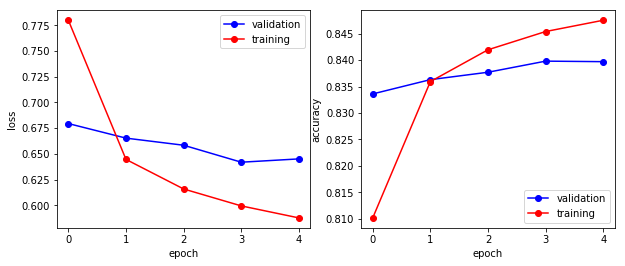

In [25]:
# Your code for visualizing train/val plots for accuracy and losses.
plt.figure(figsize = (10, 4))
plt.subplot(1, 2, 1)
plt.plot(val_losses, 'bo-', label = 'val-loss')
plt.plot(train_losses, 'ro-', label = 'train-loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['validation', 'training'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, 'bo-', label = 'val-acc')
plt.plot(train_accuracies, 'ro-', label = 'train-acc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['validation', 'training'], loc='lower right')
plt.show()

### Appendix: Finding the derivative of the loss with respect to activations $\frac{\partial \ell}{\partial a_i}$


This is the task:
$$\frac{\partial}{\partial a_{i}}\Big[-\text{log}\Big(\frac{\text{exp}(a_{label})}{\sum_{k=1}^{10}{\text{exp}(a_k)}}\Big)\Big] =
\frac{\partial}{\partial a_{i}}\Big[\text{log}(\sum_{k=1}^{10}{\text{exp}(a_k)})- a_{label}\Big]$$

How do we compute the derivatives of the loss function $\ell$ with respect to the variables $a_i$? There are two cases to consider 1) Derivative with respect to $a_{label}$ and derivative with respect to activations $a_i$ where $i\neq class$. 

Let's start considering the first case when $i = label$:

$$\frac{\partial \ell}{\partial a_{label}} = \frac{\partial}{\partial a_{label}}\Big[\text{log}(\sum_{k=1}^{10}{\text{exp}(a_k)} - a_{label})\Big]$$

$$\frac{\partial \ell}{\partial a_{label}} = \frac{\partial}{\partial a_{label}}\text{log}(\sum_{k=1}^{10}{\text{exp}(a_k)}) - 1$$

$$\frac{\partial \ell}{\partial a_{label}} =\Big(\frac{1}{\sum_{k=1}^{10}{\text{exp}(a_k)}}\Big)\Big(\frac{\partial}{\partial a_{label}}\sum_{k=1}^{10}{\text{exp}(a_k)}\Big) - 1$$

$$\frac{\partial \ell}{\partial a_{label}} = \frac{\text{exp}(a_{label})}{\sum_{k=1}^{10}{\text{exp}(a_k)}} - 1$$

$$\frac{\partial \ell}{\partial a_{label}}= \hat{y}_{label} - 1 $$

Now let's compute the second case when $i \neq label$:

$$\frac{\partial \ell}{\partial a_{i}} = \frac{\partial}{\partial a_{i}}\Big[\text{log}(\sum_{k=1}^{10}{\text{exp}(a_k)}) - a_{label}\Big]$$

$$\frac{\partial \ell}{\partial a_{i}} = \frac{\partial}{\partial a_{i}}\text{log}(\sum_{k=1}^{10}{\text{exp}(a_k)})$$

$$\frac{\partial \ell}{\partial a_{i}} =\Big(\frac{1}{\sum_{k=1}^{10}{\text{exp}(a_k)}}\Big)\Big(\frac{\partial}{\partial a_{i}}\sum_{k=1}^{10}{\text{exp}(a_k)}\Big)$$

$$\frac{\partial \ell}{\partial a_{i}} = \frac{\text{exp}(a_{i})}{\sum_{k=1}^{10}{\text{exp}(a_k)}}$$

$$\frac{\partial \ell}{\partial a_{i}} =\hat{y}_{i}$$

We can put both derivatives together using an indicator function which takes the value of 1 only when the condition inside the bracket is true:

$$\frac{\partial \ell}{\partial a_{i}} = \hat{y}_{i} - \mathbb{1}[j = label]$$

Also by remembering that we had earlier defined $y$ as the ground truth vector containing all zeros except at $y_{label}$, where it contains a 1, we can also simply write:

$$\frac{\partial \ell}{\partial a_{i}} = \hat{y}_{i} - y_i$$